In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download("stopwords")
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words("english"))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from PIL import ImageFont
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maary\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Load the Data

data = pd.read_csv("amazon_alexa.tsv", delimiter = "\t", quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [4]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [6]:
#Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [7]:
#Creating a new column "Length" that will contain the length of the string in 'verified reviews' column

data["length"] = data["verified_reviews"].apply(len)

In [8]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [9]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #value of the column 'length'


'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


In [10]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

# Analyzing 'rating' column

In [11]:
#Distinct values of 'rating' and its count

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64


In [12]:
len(data)

3150

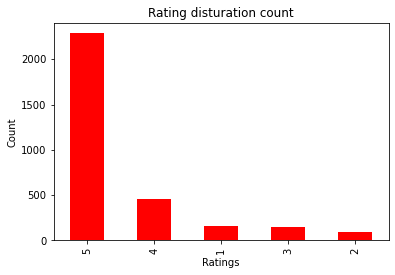

In [13]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = "red")
plt.title("Rating disturation count")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

In [14]:
#percentage distribution of each rating

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
5    72.57
4    14.44
1     5.11
3     4.83
2     3.05
Name: rating, dtype: float64


Lets plot the above values in a piechart

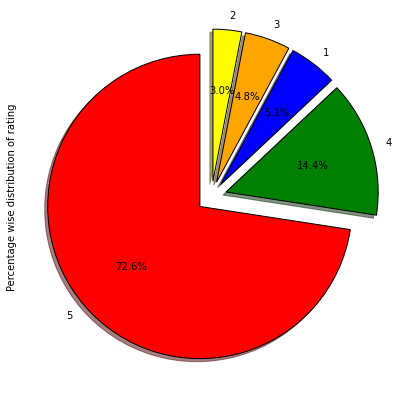

In [15]:
fig = plt.figure(figsize=(7,7))
colors = ("red", "green", "blue", "orange", "yellow")
wp = {"linewidth":1, "edgecolor":"black"}
tags = data['rating'].value_counts()/data.shape[0]
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distribution of rating')
from io import BytesIO
graph = BytesIO()
fig.savefig(graph, format="png")

# Analyzing 'feedback' cloumn

In [16]:
#Distinct values of 'feedback' and its count
print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
1    2893
0     257
Name: feedback, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.


In [17]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [18]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the examples above we can see that the feedback 0 is negative review and 1 is positive review

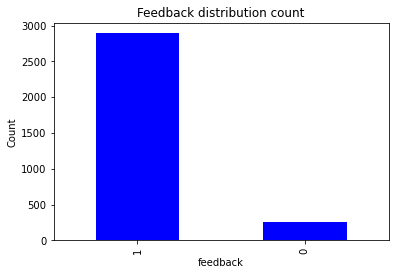

In [19]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = "blue")
plt.title("Feedback distribution count")
plt.xlabel("feedback")
plt.ylabel("Count")
plt.show()

In [20]:
#Finding the percentage distribution of each feedback

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
1    91.84
0     8.16
Name: feedback, dtype: float64


<AxesSubplot:ylabel='Percentage wise distribution of feedback'>

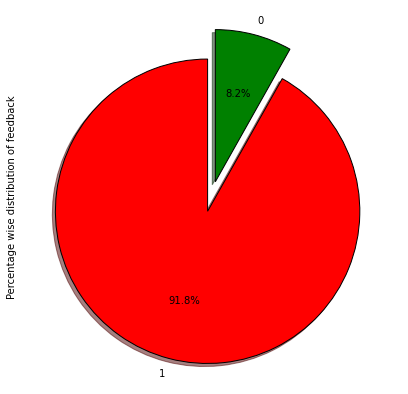

In [21]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green')
wp = {'linewidth':1, "edgecolor":'black'}
tags = data['feedback'].value_counts()/data.shape[0]
explode=(0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distribution of feedback')

Let's see the 'rating' values for different values of 'feedback'

In [22]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

1    161
2     96
Name: rating, dtype: int64

In [23]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

5    2286
4     455
3     152
Name: rating, dtype: int64

# Analyzing 'variation' column

In [24]:
#Distinct values of 'variation' and its count

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64


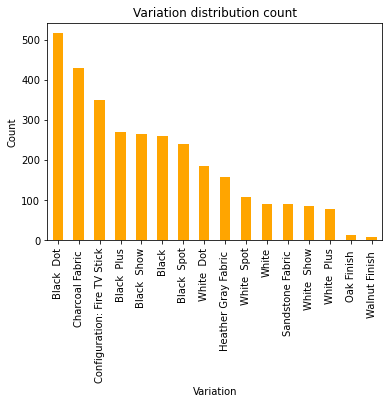

In [25]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = "orange")
plt.title("Variation distribution count")
plt.xlabel("Variation")
plt.ylabel("Count")
plt.show()

In [26]:
#Finding the percentage distribution of each variation

print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
Black  Dot                      16.38
Charcoal Fabric                 13.65
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.41
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.98
White  Spot                      3.46
White                            2.89
Sandstone Fabric                 2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: variation, dtype: float64


Mean rating according to variation

In [27]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.142857
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

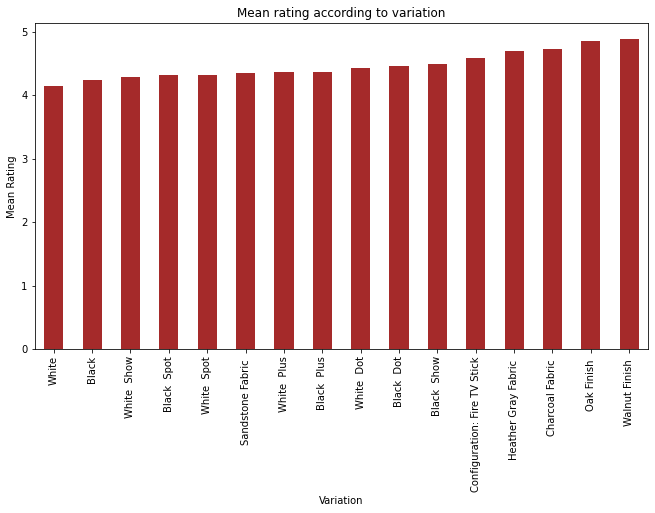

In [28]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel("Variation")
plt.ylabel("Mean Rating")
plt.show()

# Analyzing 'verified_reviews' column

In [29]:
data['length'].describe()

count    3150.000000
mean      132.673651
std       182.526953
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review ')]

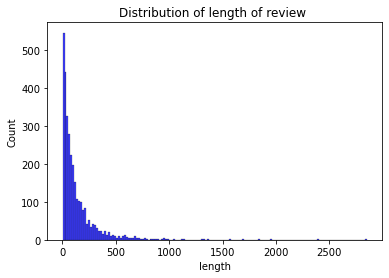

In [30]:
sns.histplot(data['length'], color = 'blue').set(title = 'Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

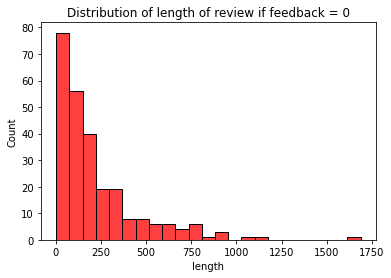

In [31]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

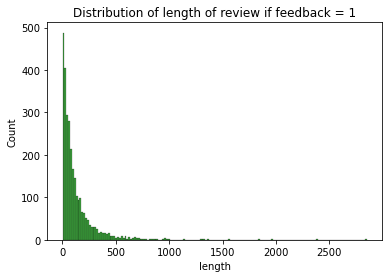

In [32]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

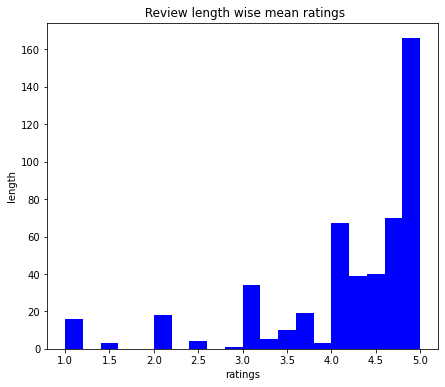

In [33]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [34]:
cv = CountVectorizer(stop_words = "english")
words = cv.fit_transform(data.verified_reviews)

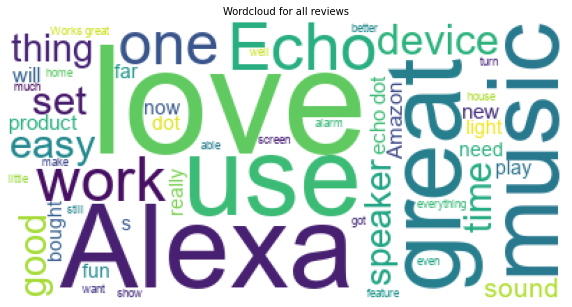

In [35]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
font_path = './arial.ttf'
wc = WordCloud(font_path=font_path , background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category


In [36]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

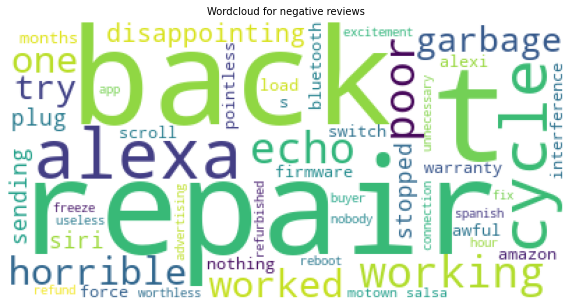

In [37]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

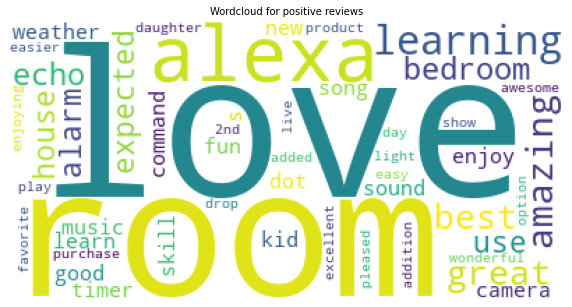

In [38]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following -

1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopwordthen add the stemmed form of the word to the corpus

In [39]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

Using Count Vectorizer to create bag of words

In [40]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and Y
x = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

Checking the shape of x and y

In [41]:
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (3150, 2500)
y shape: (3150,)


Splitting data into train and test set with 30% data with testing

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 15)

print(f"x train: {x_train.shape}")
print(f"y train: {y_train.shape}")
print(f"x test: {x_test.shape}")
print(f"y test: {y_test.shape}")

x train: (2205, 2500)
y train: (2205,)
x test: (945, 2500)
y test: (945,)


In [43]:
print(f"x train max value: {x_train.max()}")
print(f"x test max value: {x_test.max()}")

x train max value: 12
x test max value: 10


We'll scale x_train and x_test so that all values are between 0 and 1

In [44]:
scaler = MinMaxScaler()

x_train_scl = scaler.fit_transform(x_train)
x_test_scl = scaler.fit_transform(x_test)

In [46]:
import os

# Check if the directory 'Models' exists, if not, create it
models_dir = 'Models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

# Random Forest

In [49]:
#Fitting scaled x_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(x_train_scl, y_train)

RandomForestClassifier()

In [75]:
#Accuracy of the model on training and testing data

print("Training Accuracy : ", model_rf.score(x_train_scl, y_train))
print("Testing Accuracy : ", model_rf.score(x_test_scl, y_test))

Training Accuracy :  0.9941043083900227
Testing Accuracy :  0.9407407407407408


In [76]:
#Predicting on the test set
y_pred = model_rf.predict(x_test_scl)

In [77]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 23  52]
 [  4 866]]


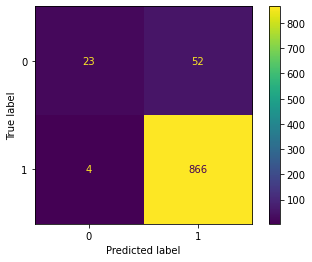

In [78]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [79]:
accuracies = cross_val_score(estimator = model_rf, X = x_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9365158371040725
Standard Variance : 0.011042440375142388


Applying grid search to get the optimal parameters on random forest



In [80]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [81]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(x_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [82]:
#Getting the best parameters from the grid search

print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}


In [83]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_pred))

Cross validation mean accuracy on train set : 96.96170257489473
Cross validation mean accuracy on test set : 92.31845626430474
Accuracy score for test set : 0.9407407407407408


# XGBoost

In [84]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [85]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(x_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(x_test_scl, y_test))

Training Accuracy : 0.9700680272108844
Testing Accuracy : 0.9343915343915344


In [86]:
y_pred = model_xgb.predict(x_test)

In [87]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 25  50]
 [ 10 860]]


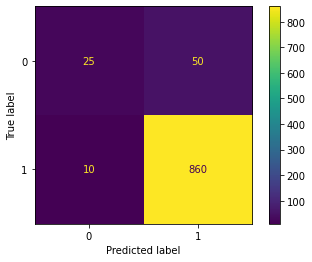

In [88]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model_xgb.classes_)
cm_display.plot()
plt.show()

In [89]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

# Decision Tree Classifier

In [90]:
model_dt = DecisionTreeClassifier()
model_dt.fit(x_train_scl, y_train)

DecisionTreeClassifier()

In [91]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(x_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(x_test_scl, y_test))

Training Accuracy : 0.9941043083900227
Testing Accuracy : 0.9068783068783068


In [92]:
y_pred = model_dt.predict(x_test)

In [93]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 38  37]
 [ 80 790]]


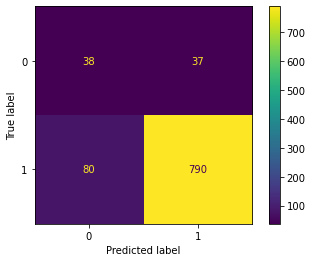

In [94]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_dt.classes_)
cm_display.plot()
plt.show()